In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.datasets import mnist
from common import plot_multiclass_calibration_curve

In [3]:
def define():
    model = Sequential([
        Lambda(lambda x: x / 255.),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(.2),
        Dense(512, activation='relu'),
        Dropout(.2),
        Dense(10, activation='softmax')
    ])
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(opitimizer=optim, metrics=['accuracy'], loss=SparseCategoricalCrossentropy())
    return model

def train(x, y, model, epochs=10):
    model.fit(x, y, 
              batch_size=32,
              epochs=epochs,
              verbose=2)
    return model

def predict(model, x, samples=20):
    '''
    Args:
        model: The trained keras model
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        probs: The expected value of our prediction
        entropy: The standard deviation of our prediction
    '''
    yhat_arr = []

    for t in range(samples):
        yhat = model(x, training=True)
        yhat_arr.append(yhat)

    yhat_arr = np.stack(yhat_arr, -1)
    probs = np.mean(yhat_arr, axis=-1)
    entropy = - 1.0 * np.sum(probs * np.log(probs + 1e-16), axis=-1)
    return probs, entropy

In [24]:
data = mnist.load_data()
x_trn = data[0][0].astype(np.float32)
y_trn = data[0][1].astype(np.float32)
x_tst = data[1][0].astype(np.float32)
y_tst = data[1][1].astype(np.float32)
model = define()
model = train(x_trn, y_trn, model, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 - 5s - loss: 0.2214 - accuracy: 0.9342
Epoch 2/5
60000/60000 - 5s - loss: 0.1316 - accuracy: 0.9668
Epoch 3/5
60000/60000 - 5s - loss: 0.1245 - accuracy: 0.9714
Epoch 4/5
60000/60000 - 5s - loss: 0.1192 - accuracy: 0.9744
Epoch 5/5
60000/60000 - 5s - loss: 0.1152 - accuracy: 0.9772


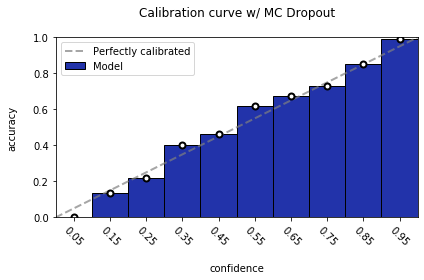

In [29]:
probs, entropy = predict(model, x_tst, samples=20)
_ = plot_multiclass_calibration_curve(probs, y_tst, bins=10, title='Calibration curve w/ MC Dropout')

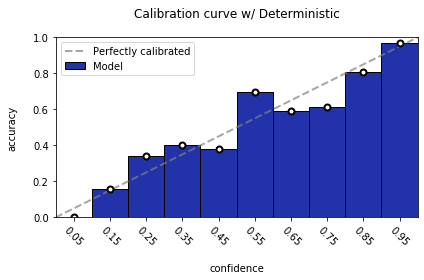

In [30]:
probs = model(x_tst, training=False).numpy()
_ = plot_multiclass_calibration_curve(probs, y_tst, bins=10, title='Calibration curve w/ Deterministic')